# 1148 Project - Walmart Store Sales Forecasting

Kang Rong 1005510608

## import necessary packages

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import table
from datetime import datetime, timedelta
from IPython.display import display, HTML

import os

# Plotting libraries
import seaborn as sns
sns.set(style='white')
import matplotlib.pyplot as plt
%matplotlib inline
import graphviz

# Sklearn libraries
from sklearn import metrics
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.model_selection import learning_curve, cross_val_score, KFold
from sklearn.svm import LinearSVC, SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import tree
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

In [2]:
cwd = os.getcwd()

In [3]:
data_dir = cwd + '/data'

In [4]:
# read store data
storesDF = pd.read_csv(data_dir + '/stores.csv')
storesDF.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


### plot out the stores of different types

Text(0.5, 1.0, 'Store types and sizes')

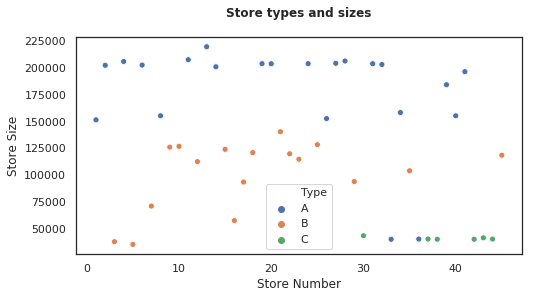

In [5]:
# plot the stores of different types
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
sns.scatterplot(x='Store',y='Size',hue='Type',data=storesDF)
ax.set_xlabel('Store Number')
ax.set_ylabel('Store Size')
ax.set_title('Store types and sizes',fontweight='bold',pad=20)

In [6]:
# read the train dataset
trainDF = pd.read_csv(data_dir + '/train.csv')
trainDF['Date'] = pd.to_datetime(trainDF['Date'])
trainDF['Date'] = trainDF['Date'].dt.date
trainDF.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [7]:
print('The train dataset covers the data from {0} to {1}'.format(trainDF.Date.min(),trainDF.Date.max()))

The train dataset covers the data from 2010-02-05 to 2012-10-26


In [8]:
# sum of the sales of all departments of each store and drop the 'Dept' feature
trainDF.drop(['Dept','IsHoliday'],1,inplace=True)
trainDF = trainDF.groupby(['Store','Date']).sum()
trainDF.reset_index(inplace=True)
trainDF = pd.merge(trainDF,storesDF,on='Store')
trainDF['Split'] = 'train'

In [9]:
trainDF.head()

,Store,Date,Weekly_Sales,Type,Size,Split
0,1,2010-02-05,1643690.90,A,151315,train
1,1,2010-02-12,1641957.44,A,151315,train
2,1,2010-02-19,1611968.17,A,151315,train
3,1,2010-02-26,1409727.59,A,151315,train
4,1,2010-03-05,1554806.68,A,151315,train


In [10]:
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 0 to 6434
Data columns (total 6 columns):
Store           6435 non-null int64
Date            6435 non-null object
Weekly_Sales    6435 non-null float64
Type            6435 non-null object
Size            6435 non-null int64
Split           6435 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 351.9+ KB


In [11]:
# read test dataset
testDF = pd.read_csv(data_dir + '/test.csv')
testDF['Date'] = pd.to_datetime(testDF['Date'])
testDF['Date'] = testDF['Date'].dt.date
testDF.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [12]:
print('The test dataset covers the data from {0} to {1}'.format(testDF.Date.min(),testDF.Date.max()))

The test dataset covers the data from 2012-11-02 to 2013-07-26


In [13]:
# group all departments of each store and delete the 'Dept' feature
testDF.drop(['Dept','IsHoliday'],1,inplace=True)
testDF = testDF.groupby(['Store','Date'])['Store','Date'].mean()
testDF.columns = ['Store_NEW']
testDF.reset_index(inplace=True)
testDF.drop('Store_NEW',1,inplace=True)
testDF = pd.merge(testDF,storesDF,on='Store')
testDF['Split'] = 'test'

In [14]:
testDF.head()

,Store,Date,Type,Size,Split
0,1,2012-11-02,A,151315,test
1,1,2012-11-09,A,151315,test
2,1,2012-11-16,A,151315,test
3,1,2012-11-23,A,151315,test
4,1,2012-11-30,A,151315,test


In [15]:
testDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1755 entries, 0 to 1754
Data columns (total 5 columns):
Store    1755 non-null int64
Date     1755 non-null object
Type     1755 non-null object
Size     1755 non-null int64
Split    1755 non-null object
dtypes: int64(2), object(3)
memory usage: 82.3+ KB


In [16]:
# read the features dataset
featuresDF = pd.read_csv(data_dir + '/features.csv')
featuresDF['Date'] = pd.to_datetime(featuresDF['Date'])
featuresDF['Date'] = featuresDF['Date'].dt.date
featuresDF = featuresDF.set_index('Date')
featuresDF.head()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
Date,,,,,,,,,,,
2010-02-05,1,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
2010-02-12,1,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2010-02-19,1,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
2010-02-26,1,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
2010-03-05,1,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [17]:
md_col = featuresDF.columns.tolist()[3:8] # get all the markdowns

In [18]:
featuresDF.isnull().sum() # check if missing data exists 

Store              0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [19]:
# find where the missing data lies in 'CPI' and 'Unemployment'
featuresDF[featuresDF['CPI'].isnull()][['Store','CPI','Unemployment']]

,Store,CPI,Unemployment
Date,,,
2013-05-03,1,NaN,NaN
2013-05-10,1,NaN,NaN
2013-05-17,1,NaN,NaN
2013-05-24,1,NaN,NaN
2013-05-31,1,NaN,NaN
2013-06-07,1,NaN,NaN
2013-06-14,1,NaN,NaN
2013-06-21,1,NaN,NaN
2013-06-28,1,NaN,NaN


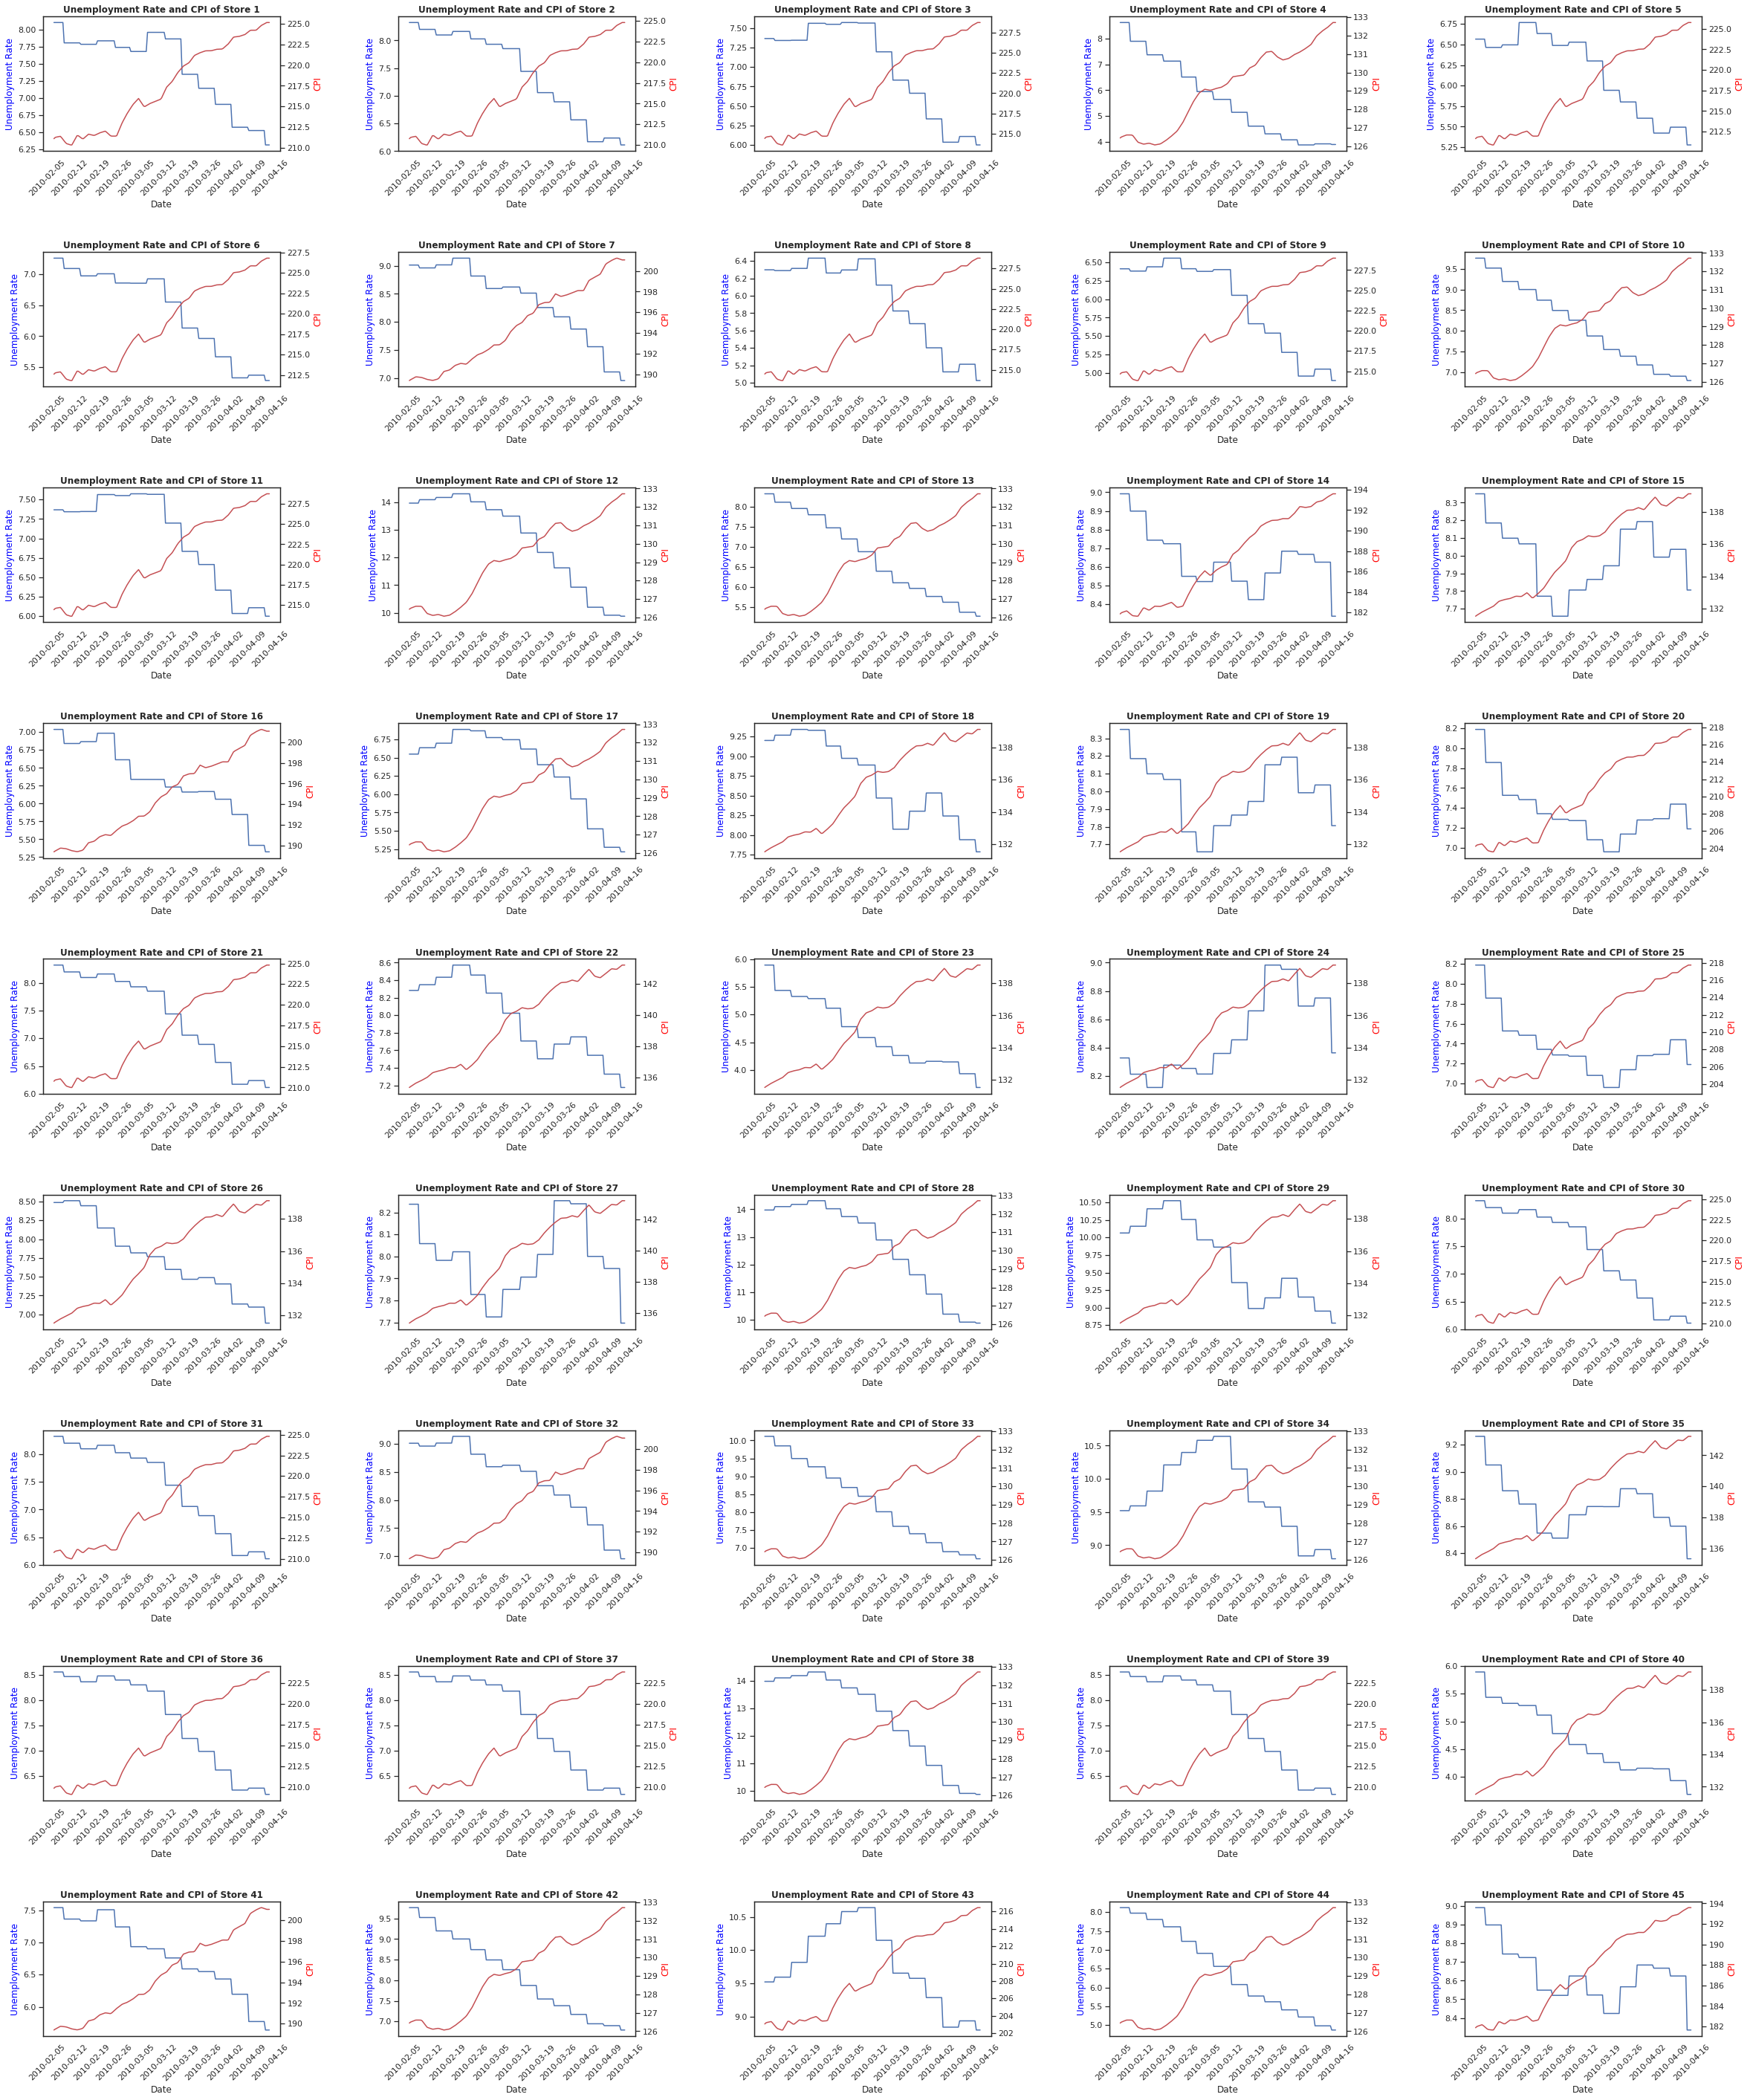

In [20]:
# plot out the trend of 'CPI' and 'Unemployment'
fig_cpi = plt.figure(figsize=(40,50))
for i in range(len(storesDF.Store.tolist())):
    na_data = featuresDF[featuresDF['Store']==i+1][['Unemployment','CPI']]
    xlabels = na_data.index
    ax1 = fig_cpi.add_subplot(9,5,i+1)
    plt.subplots_adjust(wspace=0.5,hspace=0.75)
    ax2 = ax1.twinx()
    ax1.plot(na_data.index,na_data.Unemployment,'b-')
    ax2.plot(na_data.index,na_data.CPI,'r-')
    ax1.set_xlabel('Date')
    ax1.set_xticklabels(xlabels,rotation=45)
    ax1.set_ylabel('Unemployment Rate',color='blue')
    ax2.set_ylabel('CPI',color='red')
    ax2.set_title('Unemployment Rate and CPI of Store '+str(i+1),fontweight='bold',pad=5)

In [21]:
# fig_cpi.savefig('1.jpg',orientation='landscape')

In [22]:
# fill the missing data with the last available data in 'CPI' and 'Unemployment'
for i in range(len(storesDF.Store.tolist())):
    mask = featuresDF['Store']==i+1
    featuresDF.loc[mask,'Unemployment'] = featuresDF.loc[mask,'Unemployment'].ffill()
    featuresDF.loc[mask,'CPI'] = featuresDF.loc[mask,'CPI'].ffill()

In [23]:
featuresDF = featuresDF.reset_index()

In [24]:
featuresDF['Date'] = featuresDF['Date'] = pd.to_datetime(featuresDF['Date'])

In [25]:
# extract 'Year', 'Month', 'Day' and 'Week' information
featuresDF['Year'] = featuresDF['Date'].apply(lambda x: x.year)
featuresDF['Month'] = featuresDF['Date'].apply(lambda x: x.month)
featuresDF['Day'] = featuresDF['Date'].apply(lambda x: x.day)
featuresDF['Week'] = featuresDF['Date'].dt.week

In [26]:
featuresDF.head()

,Date,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,Day,Week
0,2010-02-05,1,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010,2,5,5
1,2010-02-12,1,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,2010,2,12,6
2,2010-02-19,1,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,2010,2,19,7
3,2010-02-26,1,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,2010,2,26,8
4,2010-03-05,1,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,2010,3,5,9


Text(0.5, 1.0, 'Markdowns of Store 1 with missing data')

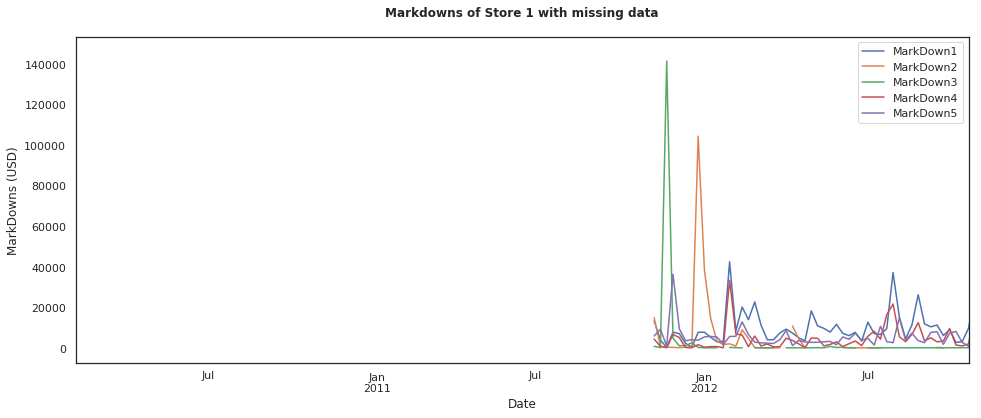

In [27]:
# plot out the markdowns
sns.set(style="white")

feature1 = featuresDF.copy().query("Store==10")
fig,ax1 = plt.subplots(figsize=(16,6))
feature1.plot(x='Date',y=md_col,ax=ax1)
llim = feature1.Date.min()
ulim = trainDF.Date.max()
ax1.set_xlim(left=llim,right=ulim)
ax1.set_xlabel('Date')
ax1.set_ylabel('MarkDowns (USD)')
ax1.set_title('Markdowns of Store 1 with missing data',fontweight='bold',pad=20)

Text(0.5, 1.0, 'Interpolated Markdowns of Store 1')

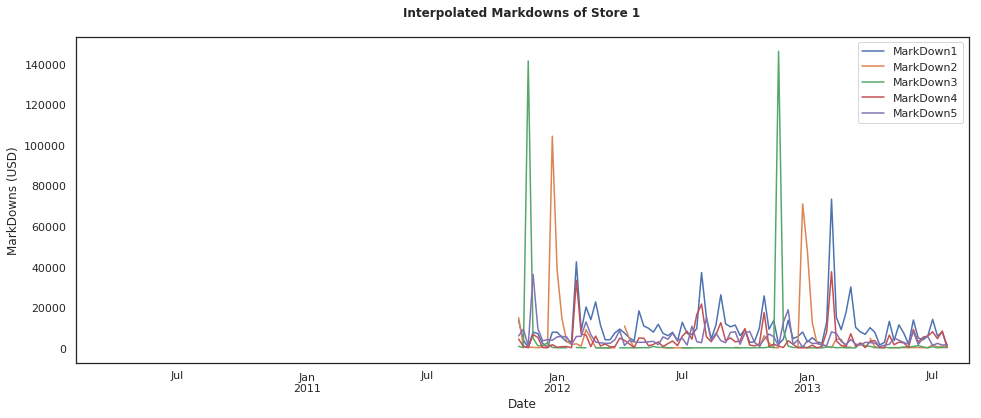

In [28]:
# plot out the markdowns
sns.set(style="white")

feature1 = featuresDF.copy().query("Store==10")
fig,ax1 = plt.subplots(figsize=(16,6))
feature1.plot(x='Date',y=md_col,ax=ax1)
llim = feature1.Date.min()
ulim = trainDF.Date.max()
ax1.set_xlim(left=llim)
ax1.set_xlabel('Date')
ax1.set_ylabel('MarkDowns (USD)')
ax1.set_title('Interpolated Markdowns of Store 1',fontweight='bold',pad=20)

In [29]:
# extract the data of markdowns for missing data manipulation
md = featuresDF.groupby(['Store','Month','Day'])[md_col+['Year']].max()

In [30]:
md = md.reset_index()

In [31]:
md.head(20)

,Store,Month,Day,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Year
0,1,1,4,1214.08,25366.33,15.01,72.36,3940.02,2013
1,1,1,6,6277.39,21813.16,143.10,1450.13,8483.00,2012
2,1,1,7,NaN,NaN,NaN,NaN,NaN,2011
3,1,1,11,6520.24,16134.60,12.17,774.55,4001.25,2013
4,1,1,13,5183.29,8025.87,42.24,453.08,3719.38,2012
5,1,1,14,NaN,NaN,NaN,NaN,NaN,2011
6,1,1,18,3772.69,3559.46,3.88,246.62,1900.40,2013
7,1,1,20,4139.87,2807.19,33.88,500.62,3400.21,2012
8,1,1,21,NaN,NaN,NaN,NaN,NaN,2011
9,1,1,25,965.89,1097.91,0.10,225.36,1831.88,2013


In [32]:
# interpolate the missing data in markdowns
md.interpolate(inplace=True)

In [33]:
md.head(15)

,Store,Month,Day,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Year
0,1,1,4,1214.080000,25366.330000,15.010,72.36,3940.020,2013
1,1,1,6,6277.390000,21813.160000,143.100,1450.13,8483.000,2012
2,1,1,7,6398.815000,18973.880000,77.635,1112.34,6242.125,2011
3,1,1,11,6520.240000,16134.600000,12.170,774.55,4001.250,2013
4,1,1,13,5183.290000,8025.870000,42.240,453.08,3719.380,2012
5,1,1,14,4477.990000,5792.665000,23.060,349.85,2809.890,2011
6,1,1,18,3772.690000,3559.460000,3.880,246.62,1900.400,2013
7,1,1,20,4139.870000,2807.190000,33.880,500.62,3400.210,2012
8,1,1,21,2552.880000,1952.550000,16.990,362.99,2616.045,2011
9,1,1,25,965.890000,1097.910000,0.100,225.36,1831.880,2013


In [34]:
md = md.sort_values(by=['Store','Year','Month','Day']).reset_index(drop=True)

In [35]:
# fill in the missing data in features dataset in markdowns
featuresDF.fillna(md,inplace=True)

In [36]:
featuresDF.head()

,Date,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,Day,Week
0,2010-02-05,1,42.31,2.572,33095.793333,1679.603333,240.770000,24419.030000,4991.320000,211.096358,8.106,False,2010,2,5,5
1,2010-02-12,1,38.51,2.548,53266.546667,6752.756667,65.353333,11500.406667,6502.133333,211.242170,8.106,True,2010,2,12,6
2,2010-02-19,1,39.93,2.514,16696.276667,5796.683333,31.400000,13241.303333,5009.460000,211.289143,8.106,False,2010,2,19,7
3,2010-02-26,1,46.63,2.561,10190.363333,2692.976667,2.933333,423.666667,4546.256667,211.319643,8.106,False,2010,2,26,8
4,2010-03-05,1,46.50,2.625,8480.853333,716.640000,56.113333,8867.726667,5153.943333,211.350143,8.106,False,2010,3,5,9


Text(0.5, 1.0, 'Interpolated Markdowns of Store 1')

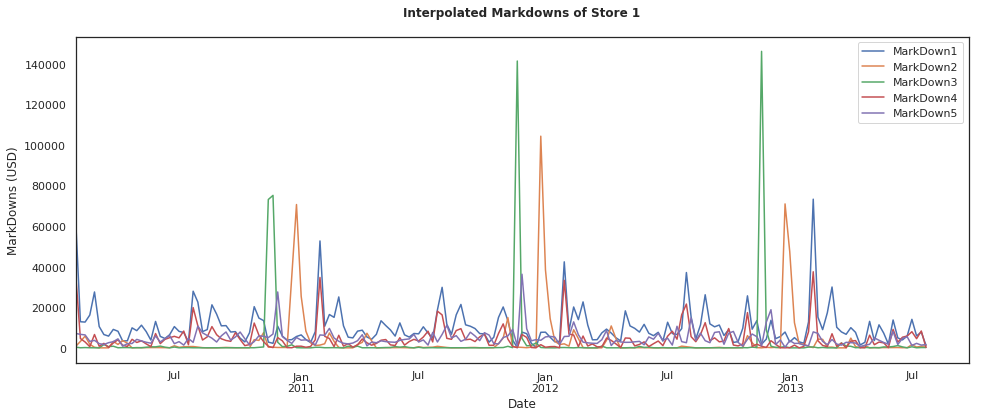

In [37]:
# plot out the markdowns after interpolation
sns.set(style="white")

feature1 = featuresDF.copy().query("Store==10")
fig,ax1 = plt.subplots(figsize=(16,6))
feature1.plot(x='Date',y=md_col,ax=ax1)
llim = feature1.Date.min()
ulim = trainDF.Date.max()
ax1.set_xlim(left=llim)
ax1.set_xlabel('Date')
ax1.set_ylabel('MarkDowns (USD)')
ax1.set_title('Interpolated Markdowns of Store 1',fontweight='bold',pad=20)

In [38]:
# merge train and test dataset
df = pd.DataFrame()
df = pd.concat([trainDF,testDF])
df.head()

,Date,Size,Split,Store,Type,Weekly_Sales
0,2010-02-05,151315,train,1,A,1643690.90
1,2010-02-12,151315,train,1,A,1641957.44
2,2010-02-19,151315,train,1,A,1611968.17
3,2010-02-26,151315,train,1,A,1409727.59
4,2010-03-05,151315,train,1,A,1554806.68


In [39]:
df['Date'] = pd.to_datetime(df['Date'])

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 1754
Data columns (total 6 columns):
Date            8190 non-null datetime64[ns]
Size            8190 non-null int64
Split           8190 non-null object
Store           8190 non-null int64
Type            8190 non-null object
Weekly_Sales    6435 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 447.9+ KB


In [41]:
# merge with features dataset to form the entire set
df = pd.merge(df,featuresDF,on=['Date','Store'])

In [42]:
df.head()

,Date,Size,Split,Store,Type,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,Day,Week
0,2010-02-05,151315,train,1,A,1643690.90,42.31,2.572,33095.793333,1679.603333,240.770000,24419.030000,4991.320000,211.096358,8.106,False,2010,2,5,5
1,2010-02-12,151315,train,1,A,1641957.44,38.51,2.548,53266.546667,6752.756667,65.353333,11500.406667,6502.133333,211.242170,8.106,True,2010,2,12,6
2,2010-02-19,151315,train,1,A,1611968.17,39.93,2.514,16696.276667,5796.683333,31.400000,13241.303333,5009.460000,211.289143,8.106,False,2010,2,19,7
3,2010-02-26,151315,train,1,A,1409727.59,46.63,2.561,10190.363333,2692.976667,2.933333,423.666667,4546.256667,211.319643,8.106,False,2010,2,26,8
4,2010-03-05,151315,train,1,A,1554806.68,46.50,2.625,8480.853333,716.640000,56.113333,8867.726667,5153.943333,211.350143,8.106,False,2010,3,5,9


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 8189
Data columns (total 20 columns):
Date            8190 non-null datetime64[ns]
Size            8190 non-null int64
Split           8190 non-null object
Store           8190 non-null int64
Type            8190 non-null object
Weekly_Sales    6435 non-null float64
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
MarkDown1       8190 non-null float64
MarkDown2       8190 non-null float64
MarkDown3       8190 non-null float64
MarkDown4       8190 non-null float64
MarkDown5       8190 non-null float64
CPI             8190 non-null float64
Unemployment    8190 non-null float64
IsHoliday       8190 non-null bool
Year            8190 non-null int64
Month           8190 non-null int64
Day             8190 non-null int64
Week            8190 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(10), int64(6), object(2)
memory usage: 1.3+ MB


Text(0.5, 1.0, 'Average Sales of Stores of Different Types')

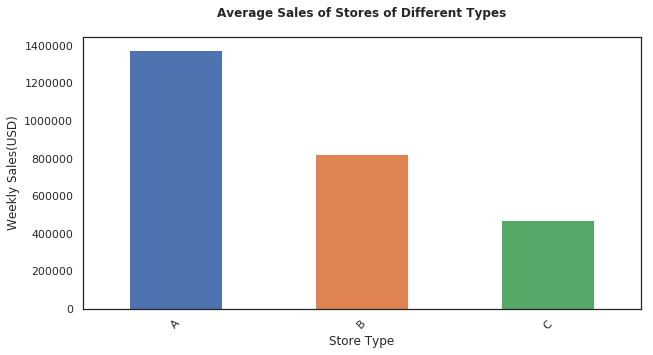

In [44]:
# check the relatioship between sales and store tyeps
df.groupby('Type').mean().plot(y='Weekly_Sales',kind='bar',figsize=(10,5),rot=45,legend=False)
plt.ylabel('Weekly Sales(USD)')
plt.xlabel('Store Type')
plt.title('Average Sales of Stores of Different Types',fontweight='bold',pad=20)
# ax.set_xtick(rotation=90)

In [45]:
# reorder to dataframe to have a better look
col = df.columns.tolist()
print(col)
print(len(col))

['Date', 'Size', 'Split', 'Store', 'Type', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday', 'Year', 'Month', 'Day', 'Week']
20


In [46]:
idx = [0,16,17,18,19,15,3,4,1,6,7,13,14,8,9,10,11,12,2,5]
columns = []
for i,num in enumerate(idx):
    columns.append(col[num])

In [47]:
df = df.reindex(columns = columns)

In [48]:
df.head()

,Date,Year,Month,Day,Week,IsHoliday,Store,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Split,Weekly_Sales
0,2010-02-05,2010,2,5,5,False,1,A,151315,42.31,2.572,211.096358,8.106,33095.793333,1679.603333,240.770000,24419.030000,4991.320000,train,1643690.90
1,2010-02-12,2010,2,12,6,True,1,A,151315,38.51,2.548,211.242170,8.106,53266.546667,6752.756667,65.353333,11500.406667,6502.133333,train,1641957.44
2,2010-02-19,2010,2,19,7,False,1,A,151315,39.93,2.514,211.289143,8.106,16696.276667,5796.683333,31.400000,13241.303333,5009.460000,train,1611968.17
3,2010-02-26,2010,2,26,8,False,1,A,151315,46.63,2.561,211.319643,8.106,10190.363333,2692.976667,2.933333,423.666667,4546.256667,train,1409727.59
4,2010-03-05,2010,3,5,9,False,1,A,151315,46.50,2.625,211.350143,8.106,8480.853333,716.640000,56.113333,8867.726667,5153.943333,train,1554806.68


In [49]:
# convert categorical to numerical
df['IsHoliday'] = df['IsHoliday'].map(lambda x: 1 if x else 0)

In [50]:
df.head()

,Date,Year,Month,Day,Week,IsHoliday,Store,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Split,Weekly_Sales
0,2010-02-05,2010,2,5,5,0,1,A,151315,42.31,2.572,211.096358,8.106,33095.793333,1679.603333,240.770000,24419.030000,4991.320000,train,1643690.90
1,2010-02-12,2010,2,12,6,1,1,A,151315,38.51,2.548,211.242170,8.106,53266.546667,6752.756667,65.353333,11500.406667,6502.133333,train,1641957.44
2,2010-02-19,2010,2,19,7,0,1,A,151315,39.93,2.514,211.289143,8.106,16696.276667,5796.683333,31.400000,13241.303333,5009.460000,train,1611968.17
3,2010-02-26,2010,2,26,8,0,1,A,151315,46.63,2.561,211.319643,8.106,10190.363333,2692.976667,2.933333,423.666667,4546.256667,train,1409727.59
4,2010-03-05,2010,3,5,9,0,1,A,151315,46.50,2.625,211.350143,8.106,8480.853333,716.640000,56.113333,8867.726667,5153.943333,train,1554806.68


### Data exploration

In [51]:
df_train = df[df['Split']=='train']

In [52]:
holidays = df_train.query('IsHoliday==True')['Date'].unique()

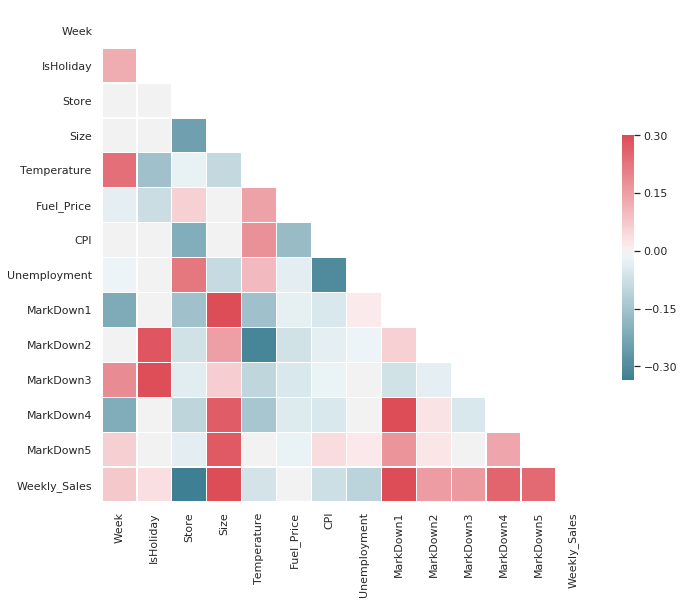

In [53]:
# plot out the corelation matrix
sns.set(style="white")

# Compute the correlation matrix
corr = df_train.drop(['Year','Month','Day'],1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [54]:
df_temp = df_train.copy()[['Date','Store','Weekly_Sales']+md_col]

Text(0.5, 1.0, 'Markdowns of Store 1')

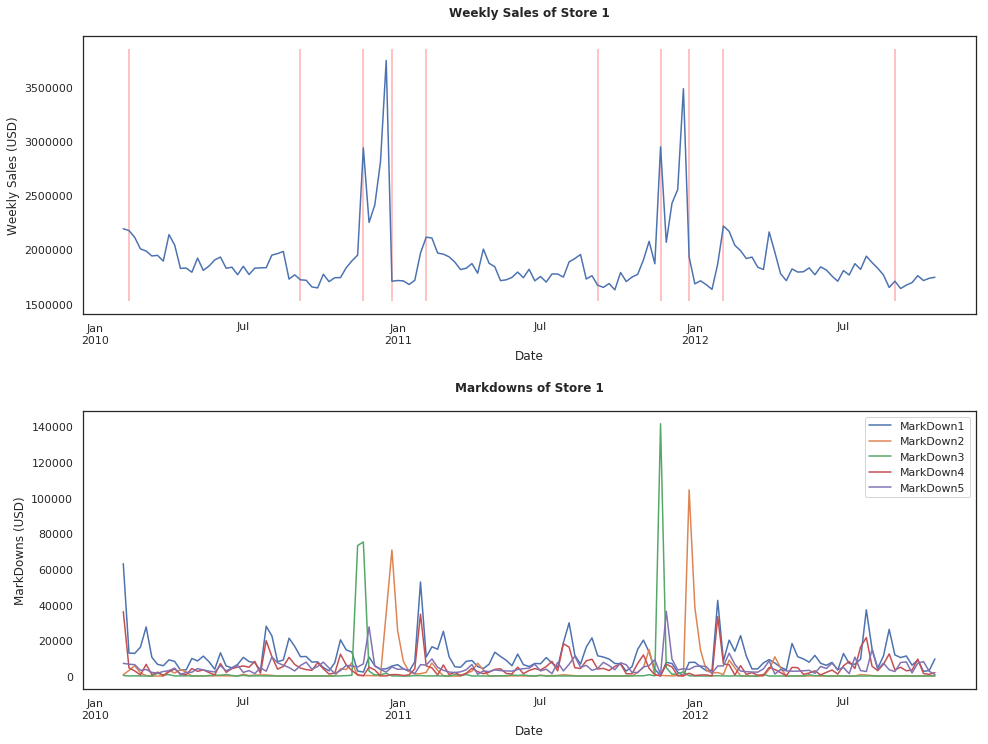

In [55]:
# plot out the sales and markdowns for store 1
df1 = df_temp.copy().query("Store==10")
fig1 = plt.subplots(figsize=(16,12))
plt.subplots_adjust(hspace=0.35)
ax1 = plt.subplot(2,1,1)
df1.plot(x='Date',y='Weekly_Sales',ax=ax1)
ax1.get_legend().remove()
ax1.set_xlabel('Date')
ax1.set_ylabel('Weekly Sales (USD)')
ax1.set_title('Weekly Sales of Store 1',fontweight='bold',pad=20)
ymin, ymax = ax1.get_ylim()
ax1.vlines(x=holidays, ymin=ymin, ymax=ymax-1, color='#ffb0b0')

ax2 = plt.subplot(2,1,2)
df1.plot(x='Date',y=md_col,ax=ax2)
ax2.set_xlabel('Date')
ax2.set_ylabel('MarkDowns (USD)')
ax2.set_title('Markdowns of Store 1',fontweight='bold',pad=20)

Text(0.5, 1.0, 'Weekly Sales of All Stores')

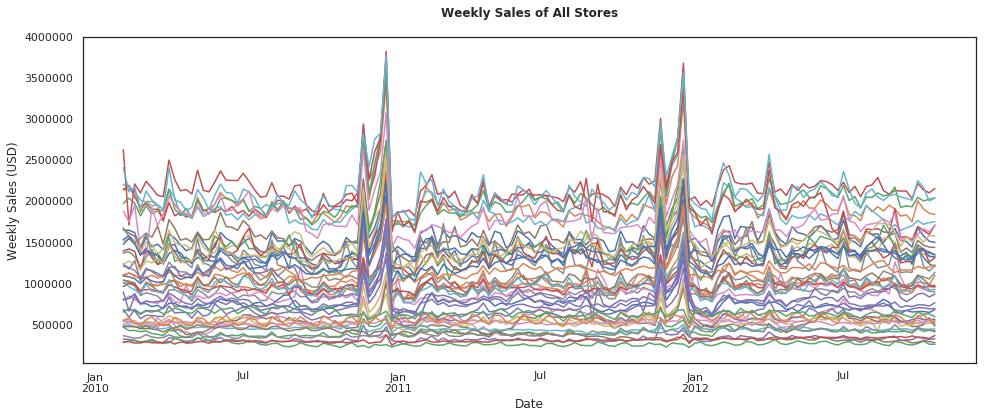

In [56]:
# plot out sales data for all stores
fig,ax = plt.subplots(figsize=(16,6))
df_temp.pivot(index='Date', columns='Store', values='Weekly_Sales').plot(ax=ax)
ax.get_legend().remove()
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Sales (USD)')
ax.set_title('Weekly Sales of All Stores',fontweight='bold',pad=20)

### Get dummies for categorical data

In [57]:
df.head()

,Date,Year,Month,Day,Week,IsHoliday,Store,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Split,Weekly_Sales
0,2010-02-05,2010,2,5,5,0,1,A,151315,42.31,2.572,211.096358,8.106,33095.793333,1679.603333,240.770000,24419.030000,4991.320000,train,1643690.90
1,2010-02-12,2010,2,12,6,1,1,A,151315,38.51,2.548,211.242170,8.106,53266.546667,6752.756667,65.353333,11500.406667,6502.133333,train,1641957.44
2,2010-02-19,2010,2,19,7,0,1,A,151315,39.93,2.514,211.289143,8.106,16696.276667,5796.683333,31.400000,13241.303333,5009.460000,train,1611968.17
3,2010-02-26,2010,2,26,8,0,1,A,151315,46.63,2.561,211.319643,8.106,10190.363333,2692.976667,2.933333,423.666667,4546.256667,train,1409727.59
4,2010-03-05,2010,3,5,9,0,1,A,151315,46.50,2.625,211.350143,8.106,8480.853333,716.640000,56.113333,8867.726667,5153.943333,train,1554806.68


In [58]:
df_copy = df # make a copy of the dataframe

In [59]:
df_copy.head()

,Date,Year,Month,Day,Week,IsHoliday,Store,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Split,Weekly_Sales
0,2010-02-05,2010,2,5,5,0,1,A,151315,42.31,2.572,211.096358,8.106,33095.793333,1679.603333,240.770000,24419.030000,4991.320000,train,1643690.90
1,2010-02-12,2010,2,12,6,1,1,A,151315,38.51,2.548,211.242170,8.106,53266.546667,6752.756667,65.353333,11500.406667,6502.133333,train,1641957.44
2,2010-02-19,2010,2,19,7,0,1,A,151315,39.93,2.514,211.289143,8.106,16696.276667,5796.683333,31.400000,13241.303333,5009.460000,train,1611968.17
3,2010-02-26,2010,2,26,8,0,1,A,151315,46.63,2.561,211.319643,8.106,10190.363333,2692.976667,2.933333,423.666667,4546.256667,train,1409727.59
4,2010-03-05,2010,3,5,9,0,1,A,151315,46.50,2.625,211.350143,8.106,8480.853333,716.640000,56.113333,8867.726667,5153.943333,train,1554806.68


In [60]:
# dummy variables for 'Type' and 'Store'
type_dummies = pd.get_dummies(df_copy['Type'],prefix='Type')
store_dummies = pd.get_dummies(df_copy['Store'],prefix='Store')

In [61]:
df_copy.head()

,Date,Year,Month,Day,Week,IsHoliday,Store,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Split,Weekly_Sales
0,2010-02-05,2010,2,5,5,0,1,A,151315,42.31,2.572,211.096358,8.106,33095.793333,1679.603333,240.770000,24419.030000,4991.320000,train,1643690.90
1,2010-02-12,2010,2,12,6,1,1,A,151315,38.51,2.548,211.242170,8.106,53266.546667,6752.756667,65.353333,11500.406667,6502.133333,train,1641957.44
2,2010-02-19,2010,2,19,7,0,1,A,151315,39.93,2.514,211.289143,8.106,16696.276667,5796.683333,31.400000,13241.303333,5009.460000,train,1611968.17
3,2010-02-26,2010,2,26,8,0,1,A,151315,46.63,2.561,211.319643,8.106,10190.363333,2692.976667,2.933333,423.666667,4546.256667,train,1409727.59
4,2010-03-05,2010,3,5,9,0,1,A,151315,46.50,2.625,211.350143,8.106,8480.853333,716.640000,56.113333,8867.726667,5153.943333,train,1554806.68


In [62]:
# find Black Friday and Christmas 
mask11 = df_copy['Month']==11
mask12 = df_copy['Month']==12

In [63]:
df_copy['Black_Friday'] = 0
df11 = df_copy[mask11][df_copy[mask11]['Day'].isin(np.arange(21,30))]
df_copy.ix[df11.index,'Black_Friday'] = 1

In [64]:
df_copy['Pre_Christmas'] = 0
df12 = df_copy[mask12][df_copy[mask12]['Day'].isin(np.arange(21,25))]
df_copy.ix[df12.index,'Pre_Christmas'] = 1

In [65]:
df_copy.head()

,Date,Year,Month,Day,Week,IsHoliday,Store,Type,Size,Temperature,...,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Split,Weekly_Sales,Black_Friday,Pre_Christmas
0,2010-02-05,2010,2,5,5,0,1,A,151315,42.31,...,8.106,33095.793333,1679.603333,240.770000,24419.030000,4991.320000,train,1643690.90,0,0
1,2010-02-12,2010,2,12,6,1,1,A,151315,38.51,...,8.106,53266.546667,6752.756667,65.353333,11500.406667,6502.133333,train,1641957.44,0,0
2,2010-02-19,2010,2,19,7,0,1,A,151315,39.93,...,8.106,16696.276667,5796.683333,31.400000,13241.303333,5009.460000,train,1611968.17,0,0
3,2010-02-26,2010,2,26,8,0,1,A,151315,46.63,...,8.106,10190.363333,2692.976667,2.933333,423.666667,4546.256667,train,1409727.59,0,0
4,2010-03-05,2010,3,5,9,0,1,A,151315,46.50,...,8.106,8480.853333,716.640000,56.113333,8867.726667,5153.943333,train,1554806.68,0,0


In [66]:
df_copy = pd.concat([df_copy,type_dummies,store_dummies],axis=1)

In [67]:
df_copy.head()

,Date,Year,Month,Day,Week,IsHoliday,Store,Type,Size,Temperature,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
0,2010-02-05,2010,2,5,5,0,1,A,151315,42.31,...,0,0,0,0,0,0,0,0,0,0
1,2010-02-12,2010,2,12,6,1,1,A,151315,38.51,...,0,0,0,0,0,0,0,0,0,0
2,2010-02-19,2010,2,19,7,0,1,A,151315,39.93,...,0,0,0,0,0,0,0,0,0,0
3,2010-02-26,2010,2,26,8,0,1,A,151315,46.63,...,0,0,0,0,0,0,0,0,0,0
4,2010-03-05,2010,3,5,9,0,1,A,151315,46.50,...,0,0,0,0,0,0,0,0,0,0


In [68]:
# drop useless features
col_droplist = ['Year','Month','Day','Store','Type','Temperature','Fuel_Price']

In [69]:
df_copy.drop(col_droplist,axis=1,inplace=True)

In [70]:
df_copy.head()

,Date,Week,IsHoliday,Size,CPI,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
0,2010-02-05,5,0,151315,211.096358,8.106,33095.793333,1679.603333,240.770000,24419.030000,...,0,0,0,0,0,0,0,0,0,0
1,2010-02-12,6,1,151315,211.242170,8.106,53266.546667,6752.756667,65.353333,11500.406667,...,0,0,0,0,0,0,0,0,0,0
2,2010-02-19,7,0,151315,211.289143,8.106,16696.276667,5796.683333,31.400000,13241.303333,...,0,0,0,0,0,0,0,0,0,0
3,2010-02-26,8,0,151315,211.319643,8.106,10190.363333,2692.976667,2.933333,423.666667,...,0,0,0,0,0,0,0,0,0,0
4,2010-03-05,9,0,151315,211.350143,8.106,8480.853333,716.640000,56.113333,8867.726667,...,0,0,0,0,0,0,0,0,0,0


In [71]:
col = df.columns.tolist()
print(col)
print(len(col))

['Date', 'Year', 'Month', 'Day', 'Week', 'IsHoliday', 'Store', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Split', 'Weekly_Sales', 'Black_Friday', 'Pre_Christmas']
22


In [72]:
idx = [0,1,2,3,15,16,17,4,5,6,7,8,9,10,13,14,12,11]
columns = []
for i,num in enumerate(idx):
    columns.append(col[num])

In [73]:
df_copy.reindex(columns = columns)

,Date,Year,Month,Day,MarkDown3,MarkDown4,MarkDown5,Week,IsHoliday,Store,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,Unemployment,CPI
0,2010-02-05,NaN,NaN,NaN,240.770000,24419.030000,4991.320000,5,0,NaN,NaN,151315,NaN,NaN,33095.793333,1679.603333,8.106,211.096358
1,2010-02-12,NaN,NaN,NaN,65.353333,11500.406667,6502.133333,6,1,NaN,NaN,151315,NaN,NaN,53266.546667,6752.756667,8.106,211.242170
2,2010-02-19,NaN,NaN,NaN,31.400000,13241.303333,5009.460000,7,0,NaN,NaN,151315,NaN,NaN,16696.276667,5796.683333,8.106,211.289143
3,2010-02-26,NaN,NaN,NaN,2.933333,423.666667,4546.256667,8,0,NaN,NaN,151315,NaN,NaN,10190.363333,2692.976667,8.106,211.319643
4,2010-03-05,NaN,NaN,NaN,56.113333,8867.726667,5153.943333,9,0,NaN,NaN,151315,NaN,NaN,8480.853333,716.640000,8.106,211.350143
5,2010-03-12,NaN,NaN,NaN,12.433333,1968.210000,3109.393333,10,0,NaN,NaN,151315,NaN,NaN,5982.433333,79.690000,8.106,211.380643
6,2010-03-19,NaN,NaN,NaN,330.740000,5433.383333,2369.670000,11,0,NaN,NaN,151315,NaN,NaN,9802.040000,8.490000,8.106,211.215635
7,2010-03-26,NaN,NaN,NaN,258.256667,224.193333,3821.606667,12,0,NaN,NaN,151315,NaN,NaN,10751.160000,4.990000,8.106,211.018042
8,2010-04-02,NaN,NaN,NaN,327.396667,870.083333,4275.813333,13,0,NaN,NaN,151315,NaN,NaN,12018.086667,3792.073333,7.808,210.820450
9,2010-04-09,NaN,NaN,NaN,61.233333,1882.910000,3394.666667,14,0,NaN,NaN,151315,NaN,NaN,5822.276667,2121.400000,7.808,210.622857


In [74]:
df_copy.head()

,Date,Week,IsHoliday,Size,CPI,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
0,2010-02-05,5,0,151315,211.096358,8.106,33095.793333,1679.603333,240.770000,24419.030000,...,0,0,0,0,0,0,0,0,0,0
1,2010-02-12,6,1,151315,211.242170,8.106,53266.546667,6752.756667,65.353333,11500.406667,...,0,0,0,0,0,0,0,0,0,0
2,2010-02-19,7,0,151315,211.289143,8.106,16696.276667,5796.683333,31.400000,13241.303333,...,0,0,0,0,0,0,0,0,0,0
3,2010-02-26,8,0,151315,211.319643,8.106,10190.363333,2692.976667,2.933333,423.666667,...,0,0,0,0,0,0,0,0,0,0
4,2010-03-05,9,0,151315,211.350143,8.106,8480.853333,716.640000,56.113333,8867.726667,...,0,0,0,0,0,0,0,0,0,0


### Model Preparation

In [75]:
# get the train set and test. Train set will be further split into train and test set
df_train = df_copy[df_copy['Split']=='train']
df_test = df_copy[df_copy['Split']=='test']

In [76]:
df_train.drop('Split',1).head()

,Date,Week,IsHoliday,Size,CPI,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
0,2010-02-05,5,0,151315,211.096358,8.106,33095.793333,1679.603333,240.770000,24419.030000,...,0,0,0,0,0,0,0,0,0,0
1,2010-02-12,6,1,151315,211.242170,8.106,53266.546667,6752.756667,65.353333,11500.406667,...,0,0,0,0,0,0,0,0,0,0
2,2010-02-19,7,0,151315,211.289143,8.106,16696.276667,5796.683333,31.400000,13241.303333,...,0,0,0,0,0,0,0,0,0,0
3,2010-02-26,8,0,151315,211.319643,8.106,10190.363333,2692.976667,2.933333,423.666667,...,0,0,0,0,0,0,0,0,0,0
4,2010-03-05,9,0,151315,211.350143,8.106,8480.853333,716.640000,56.113333,8867.726667,...,0,0,0,0,0,0,0,0,0,0


In [77]:
# exlanatory variable and target variable
X = df_train.drop(['Date','Weekly_Sales','Split'],axis=1)
y = df_train['Weekly_Sales']

In [78]:
# split the test data by 7:3
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=101)

### Random Forest Regression

In [79]:
np.random.seed(100)

In [80]:
# random forest regressor
rf_regr = RandomForestRegressor()

In [81]:
# fit the train set
rf_regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [82]:
# prediction on train and test
y_pred_train = rf_regr.predict(X_train)
y_pred = rf_regr.predict(X_test)

### Plot out the fitting result for both train and test set

(array([-500000.,       0.,  500000., 1000000., 1500000., 2000000.,
        2500000., 3000000., 3500000.]), <a list of 9 Text xticklabel objects>)

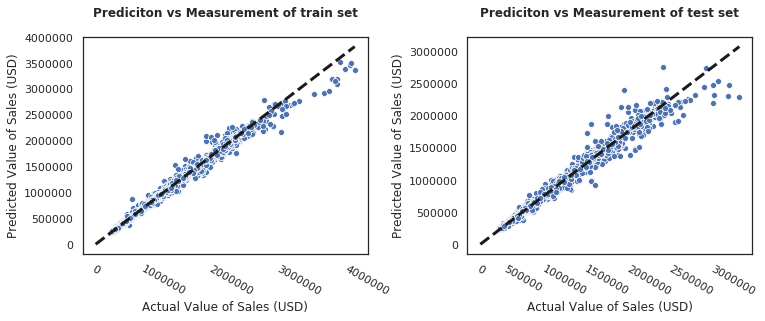

In [83]:
fig = plt.subplots(figsize=(12,4))
plt.subplots_adjust(wspace=0.35)

ax1 = plt.subplot(1,2,1)
sns.scatterplot(x=y_train,y=y_pred_train,edgecolors=(0, 0, 0))
plt.plot([0,y_train.max()],[0,y_train.max()],'k--',linewidth=3)
ax1.set_title('Prediciton vs Measurement of train set',fontweight='bold',pad=20)
ax1.set_xlabel('Actual Value of Sales (USD)')
ax1.set_ylabel('Predicted Value of Sales (USD)')
plt.xticks(rotation=-30)

ax2 = plt.subplot(1,2,2)
sns.scatterplot(x=y_test,y=y_pred,edgecolors=(0, 0, 0))
plt.plot([0,y_test.max()],[0,y_test.max()],'k--',linewidth=3)
ax2.set_title('Prediciton vs Measurement of test set',fontweight='bold',pad=20)
ax2.set_xlabel('Actual Value of Sales (USD)')
ax2.set_ylabel('Predicted Value of Sales (USD)')
plt.xticks(rotation=-30)

### Evaluate the result with MAE WMAE and RSME

In [84]:
w_train = X_train.IsHoliday.map(lambda v: 5 if v else 1).values # weights on holidays

mae_train = np.mean(np.abs(y_pred_train-y_train))
wmae_train = np.sum(w_train*(y_pred_train-y_train)) / np.sum(w_train)
rmse_train = np.sqrt(np.mean((y_pred_train-y_train)**2))
print('\n')
print('MAE\t\tWMAE\t\tRMSE')
print(41*'-')
print('{0:.3f}\t{1:.3f}\t{2:.3f}'.format(mae_train,wmae_train,rmse_train))



MAE		WMAE		RMSE
-----------------------------------------
23335.988	823.730	44677.807


In [85]:
w_test = X_test.IsHoliday.map(lambda v: 5 if v else 1).values # weights on holidays

mae_test = np.mean(np.abs(y_pred-y_test))
wmae_test = np.sum(w_test*(y_pred-y_test)) / np.sum(w_test)
rmse_test = np.sqrt(np.mean((y_pred-y_test)**2))
print('\n')
print('MAE\t\tWMAE\t\tRMSE')
print(42*'-')
print('{0:.3f}\t{1:.3f}\t{2:.3f}'.format(mae_test,wmae_test,rmse_test))



MAE		WMAE		RMSE
------------------------------------------
56578.322	-637.938	95837.187


### Hyperparameter Tuning

In [86]:
# parameter sets to try
param_grids =  {'n_estimators': [int(x) for x in np.arange(10,50,10)],
                      'max_features': ['auto','sqrt','log2'],
                      'max_depth': [int(x) for x in np.arange(1,5)] + [None],
                      'min_samples_split': [2,5,10],
                      'min_samples_leaf': [1,2,4],
                      'bootstrap': [True,False],
                      }

In [87]:
# try the different sets of hyperparameters
rf_regr_tune = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, max_features=0.9, 
                      max_leaf_nodes=None, min_impurity_decrease=0.0, 
                      min_impurity_split=None, bootstrap=True, 
                      oob_score=False, n_jobs=-1, random_state=42, 
                      verbose=2, warm_start=False)

In [88]:
rf_regr_tune.fit(X_train,y_train) # fit the model with train dataset

building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100building tree 6 of 100building tree 7 of 100building tree 8 of 100







building tree 9 of 100
building tree 10 of 100
building tree 11 of 100building tree 12 of 100
building tree 13 of 100

building tree 14 of 100
building tree 15 of 100building tree 16 of 100

building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100building tree 30 of 100

building tree 31 of 100
building tree 32 of 100
building tree 33 of 100building tree 34 of 100

building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100building tree 46 of 100

building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100building tree 55 of 100

building tree 56 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100building tree 61 of 100
building tree 62 of 100

building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100building tree 67 of 100

building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100building tree 76 of 100

building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.9, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=2, warm_start=False)

In [89]:
# predict sales with tuned regressor
y_pred_train_tune = rf_regr_tune.predict(X_train)
y_pred_tune = rf_regr_tune.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


### plot out the fit result for both train and test dataset

(array([-500000.,       0.,  500000., 1000000., 1500000., 2000000.,
        2500000., 3000000., 3500000.]), <a list of 9 Text xticklabel objects>)

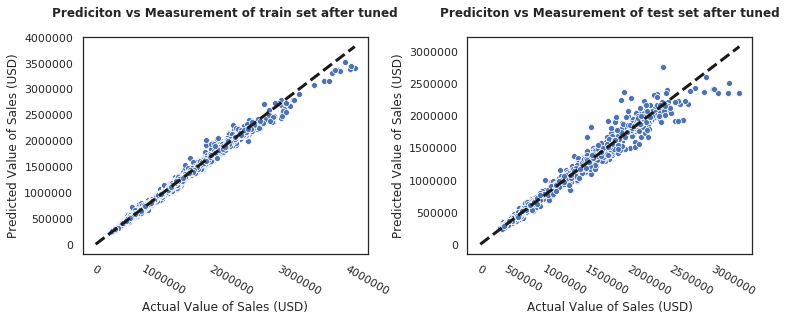

In [90]:
fig = plt.subplots(figsize=(12,4))
plt.subplots_adjust(wspace=0.35)

ax1 = plt.subplot(1,2,1)
sns.scatterplot(x=y_train,y=y_pred_train_tune,edgecolors=(0, 0, 0))
plt.plot([0,y_train.max()],[0,y_train.max()],'k--',linewidth=3)
ax1.set_title('Prediciton vs Measurement of train set after tuned',fontweight='bold',pad=20)
ax1.set_xlabel('Actual Value of Sales (USD)')
ax1.set_ylabel('Predicted Value of Sales (USD)')
plt.xticks(rotation=-30)

ax2 = plt.subplot(1,2,2)
sns.scatterplot(x=y_test,y=y_pred_tune,edgecolors=(0, 0, 0))
plt.plot([0,y_test.max()],[0,y_test.max()],'k--',linewidth=3)
ax2.set_title('Prediciton vs Measurement of test set after tuned',fontweight='bold',pad=20)
ax2.set_xlabel('Actual Value of Sales (USD)')
ax2.set_ylabel('Predicted Value of Sales (USD)')
plt.xticks(rotation=-30)

### Evaluate the fitting reults with MAE WMAE and RMSE

In [91]:
mae_train_tune = np.mean(np.abs(y_pred_train_tune-y_train))
wmae_train_tune = np.sum(w_train*(y_pred_train_tune-y_train)) / np.sum(w_train)
rmse_train_tune = np.sqrt(np.mean((y_pred_train_tune-y_train)**2))
print('\n')
print('MAE\t\tWMAE\t\tRMSE')
print(41*'-')
print('{0:.3f}\t{1:.3f}\t\t{2:.3f}'.format(mae_train_tune,wmae_train_tune,rmse_train_tune))



MAE		WMAE		RMSE
-----------------------------------------
20544.185	614.912		36081.837


In [92]:
mae_tune = np.mean(np.abs(y_pred_tune-y_test))
wmae_tune = np.sum(w_test*(y_pred_tune-y_test)) / np.sum(w_test)
rmse_tune = np.sqrt(np.mean((y_pred_tune-y_test)**2))
print('\n')
print('MAE\t\tWMAE\t\tRMSE')
print(41*'-')
print('{0:.3f}\t{1:.3f}\t{2:.3f}'.format(mae_tune,wmae_tune,rmse_tune))



MAE		WMAE		RMSE
-----------------------------------------
54050.577	1711.028	91482.742


### Display the Importance of Features

Text(0, 0.5, 'Import Score')

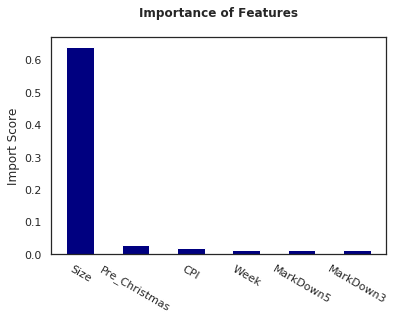

In [93]:
f_name=[]
f_imp=[]
store_dummy_list = ['Store_%s'%i for i in range(1,46)]
cols_needed = df_train.drop(['Split','Weekly_Sales','Date','Type_A','Type_B','Type_C']+store_dummy_list,1).columns.tolist()
c=0
myzip=zip(cols_needed, rf_regr_tune.feature_importances_)
f, ax = plt.subplots(figsize=(6, 4))
for name, importance in sorted(myzip, key=lambda x: x[1],reverse=True):
    f_name.append(name)
    f_imp.append(importance)
    if(c==5):
        break
    c+=1
width = 1/2 
plt.bar(f_name, f_imp, width, color="navy")
plt.xticks(rotation=-30)
plt.title('Importance of Features',fontweight='bold',pad=20)
plt.ylabel('Import Score')

## Prediction on Test

In [94]:
# make a copy of df_copy for later use
df_testpred = df_copy.copy()

In [95]:
# drop the features not used in the regression model
df_testpred.drop(['Weekly_Sales','Split','Date'],1,inplace=True)

In [96]:
# fit the model on the test dataset
test_pred_new = rf_regr_tune.predict(df_testpred)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [97]:
# merge the prediction result into orginal dataframe
df['Sales_Predict'] = test_pred_new

### Model Validation and Sales Prediction for Store 10

Text(0.5, 1.0, 'Weekly Sales of Store 10')

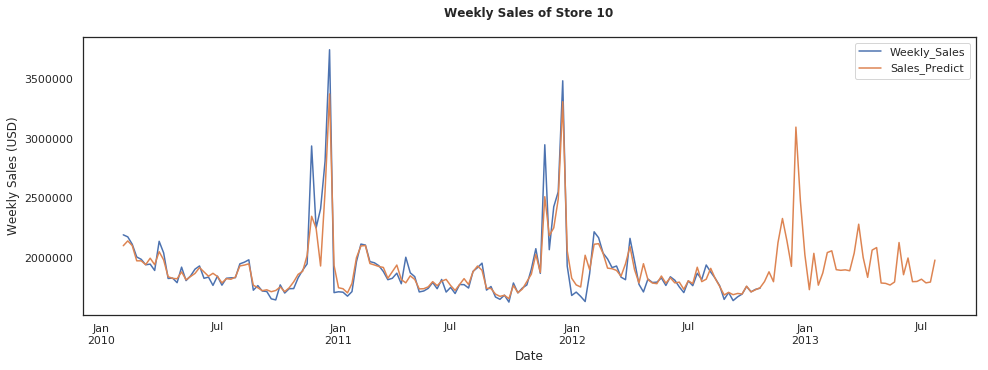

In [98]:
df10 = df.copy().query("Store==10")
fig1 = plt.subplots(figsize=(16,12))
plt.subplots_adjust(hspace=0.35)
ax1 = plt.subplot(2,1,1)
df10.plot(x='Date',y=['Weekly_Sales','Sales_Predict'],ax=ax1)

ax1.set_xlabel('Date')
ax1.set_ylabel('Weekly Sales (USD)')
ax1.set_title('Weekly Sales of Store 10',fontweight='bold',pad=20)

### Model Validation and Sales Prediction for all stores

Text(0.5, 1.0, 'Weekly Sales of All Stores')

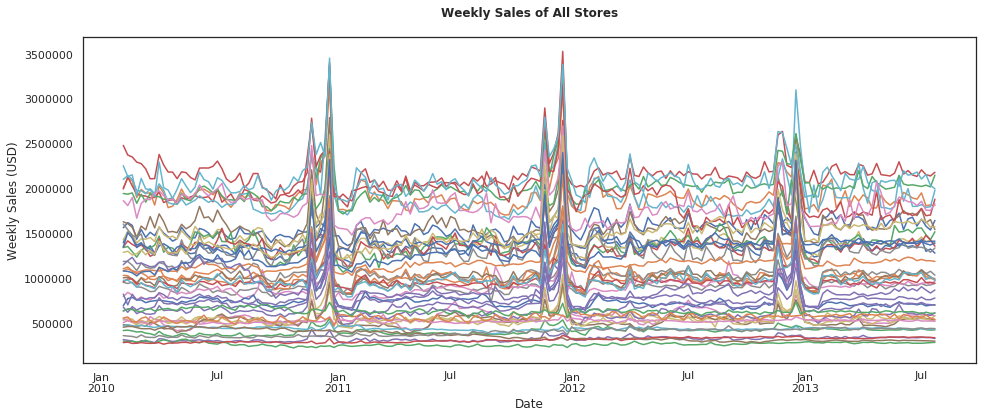

In [99]:
fig,ax = plt.subplots(figsize=(16,6))
df.pivot(index='Date', columns='Store', values='Sales_Predict').plot(ax=ax)
ax.get_legend().remove()
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Sales (USD)')
ax.set_title('Weekly Sales of All Stores',fontweight='bold',pad=20)